# <center>Tarea 4<center>
# <center>Para entregar el 13 de noviembre<center>

## 1. En este ejercicio, implementarás un modelo de lenguaje a nivel de caracteres. Considera el siguiente código base para un texto en particular.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import keras
import numpy as np
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,Conv3D,LSTM,Bidirectional

In [2]:
# en este ejemplo, se usa éste texto...
path = '/content/drive/My Drive/Tarea4/nietzsche.txt'
text = open(path).read().lower()
print('Corpus length:', len(text))

Corpus length: 600893


Definimos las secuencias, vocabulario y demás cosas para el modelo

In [ ]:
# Length of extracted character sequences
maxlen = 60
# We sample a new sequence every `step` characters
step = 3
# This holds our extracted sequences
sentences = []
# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 200278
Unique characters: 57
Vectorization...


Ahora, considera éste modelo como el baseline

In [ ]:
model = Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               95232     
_________________________________________________________________
dense (Dense)                (None, 57)                7353      
Total params: 102,585
Trainable params: 102,585
Non-trainable params: 0
_________________________________________________________________


Lo siguiente es entrenar el modelo, dar una secuencia inicial y generar texto a partir de esto. 
Una modificación para tratar de evitar la repetitividad de las secuencias generadas (sobre todo en las primeras épocas del entrenamiento), es modificar la distribución de probabilidad `softmax` para introducir cierta aleatoriedad en el proceso de muestreo (stochastic sampling). A partir de cierto parámetro ("temperatura"), se construye una nueva distribución de probabilidad de las salidas del modelo. El siguiente código implementa ésta idea.

In [3]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

El modelo de lenguaje queda entonces como

In [4]:
import random
import sys

In [ ]:
for epoch in range(1, 60):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    model.fit(x, y,
              batch_size=128,
              epochs=1)

    # Select a text seed at random
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('--- Generating with seed: "' + generated_text + '"')

    for temperature in [0.5, 1.0]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # We generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
1565/1565 [==============================] - 10s 7ms/step - loss: 1.9595
--- Generating with seed: "letion, of final unity--it is the "sabbath of
sabbaths," to "
------ temperature: 0.5
letion, of final unity--it is the "sabbath of
sabbaths," to life of the conseqlection have a more leads and the creation and the arible the meand of the way it is the have the beever the staken strengure and the man maniunds the faurity of
the belief indecisifice of the struction what he comes and
acts of himself and the freeht and the privide to the manition the selically paraling for the made of the entrus langer and the daving progation the seife and al
------ temperature: 1.0
 the entrus langer and the daving progation the seife and all this intluation. and discertinally one the impirtace of vout of the byualler ghdytruoumaniny
wisue was its alutglies of the late and lejuso icon it suthe opposly
ovility--when
sever--mant getmer laigity, subleaks tench.=
 wanith dom, and if the
himself, which

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


s the fir and more animated seeming--so arreary in the stirle man as the formation, ad
uncalled times, and an
indirmed in his permits fill one virtuuctions in our expressquenclan its oy knowing hocuus englestile and wearificy that the sous consemenious man ob. he curc" of erro's partiere.
epoch 33
1565/1565 [==============================] - 10s 6ms/step - loss: 1.2870
--- Generating with seed: "zzing about is
disagreeable; and we punish a criminal and in"
------ temperature: 0.5
zzing about is
disagreeable; and we punish a criminal and in the premasting wholly desire in the conscience of another and senses to the conduct and all the world and desire that he seems the opinions of the same mainted in the
present, and course, but as in which we conceals the world to conscience, and when the toman and part of mankind or the a men are present the things and artistic persons of the freedom of the felling
has the our explained at the sam
------ temperature: 1.0
 the freedom of the felling
ha

### a) Adapta el modelo anterior y aplícalo al texto contenido en el archivo `@lopezobrador__tweets.csv`, que contiene el historial de tuits bajados de la cuenta oficial de Andres Manuel López Obrador. Realiza el preproceso que creas conveniente en el texto. Puedes modificar los parámetros del modelo, pero reporta todos los ajustes que hiciste. Realiza pruebas con distintos valores de temperatura y da tu opinión sobre la `calidad` del texto generado.

In [5]:
path = '/content/drive/My Drive/Tarea4/lopezobrador__tweets.csv'
text = open(path).read().lower()
print('Corpus length:', len(text))

Corpus length: 629968


In [6]:
text[0:1500]

'id,created_at,text\n1324338757902823425,2020-11-05 13:12:19,el déficit de médicos y especialistas es el saldo de la política neoliberal y tiene que resolverse. conferencia matutina. https://t.co/utbvq33iut\n1323976025655578625,2020-11-04 13:10:57,seguiremos apostando al fortalecimiento de la economía popular. conferencia matutina. https://t.co/btuf3g9p2k\n1323771220127526915,2020-11-03 23:37:08,"recibí a mario delgado, quien me informó que pedirá licencia como legislador para asumir la presidencia de morena. le agradecí que como coordinador en la cámara de diputados nos apoyó en la aprobación de reformas constitucionales que están cimentando la transformación de méxico. https://t.co/03uibuqysi"\n1323611558677630980,2020-11-03 13:02:41,"la pandemia de #covid19 está activa, no debemos relajar las medidas. conferencia matutina. https://t.co/bwyrxw0mg5"\n1322632310911651842,2020-10-31 20:11:30,"lamento mucho el fallecimiento del obispo arturo lona por su trabajo ejemplar en favor de los m

Lo primero que notamos del texto es que contiene mucha información que puede causar ruido y ocasionar que se produzcan secuencias sin sentido, tales como las direcciones url, las fechas, horas, etc. Es por esto que como parte del preprocesamiento que se hará al texto se eliminan:
1. Todas las direcciones URL
2. Todas las fechas y horas de publicación de tweets
3. Todas las secuencias que inician con '\n' y que tienen una gran cantidad de números (que parecen ser el id de cada tweet)

Una característica que facilita este preprocesamiento, es el hecho de que cada una de estas secuencias están separadas del resto del texto por una coma. Se dejan los puntos, comas, comillas y demás caracteres especiales porque sí pueden formar parte del tweet.

In [7]:
ix_in=[]
ix_fn=[]
for i in range(len(text)):
  if text[i:i+8]=='https://':
    j=i
    flag=1
    ix_in.append(i)
    while flag!=0:
      if text[j]==',':
        ix_fn.append(j+1)
        flag=0
      j=j+1

In [8]:
numeros = list(range(10))
numeros = [str(nn) for nn in numeros]

In [9]:
for i in range(len(text)):
  if text[i] in numeros and text[i+4]=='-' and text[i+19]==',':
    ix_in.append(i)
    ix_fn.append(i+20)

In [10]:
for i in range(len(text)-1):
  if text[i:i+1]=='\n':
    j=i
    flag=1
    ix_in.append(i)
    while flag!=0:
      if text[j]==',':
        ix_fn.append(j+1)
        flag=0
      j=j+1

In [11]:
items=[]
items.append('id,created_at,text')
for i in range(len(ix_in)):
  items.append(text[ix_in[i]:ix_fn[i]])

for it in items:
  text=text.replace(it,'')

Visualizamos algunos caracteres de nuestro texto para verificar cómo quedó sin todas estas secuencias.

In [12]:
text[0:1000]

'el déficit de médicos y especialistas es el saldo de la política neoliberal y tiene que resolverse. conferencia matutina. seguiremos apostando al fortalecimiento de la economía popular. conferencia matutina. "recibí a mario delgado, quien me informó que pedirá licencia como legislador para asumir la presidencia de morena. le agradecí que como coordinador en la cámara de diputados nos apoyó en la aprobación de reformas constitucionales que están cimentando la transformación de méxico. "la pandemia de #covid19 está activa, no debemos relajar las medidas. conferencia matutina. "lamento mucho el fallecimiento del obispo arturo lona por su trabajo ejemplar en favor de los más pobres, como lo dije cuando me visitó en palacio nacional el 26 de febrero de 2019. "ofrenda homenaje a víctimas de la pandemia, desde palacio nacional. "acciones de mejoramiento urbano, desde cuernavaca, morelos. "inauguración de la universidad para el bienestar benito juárez garcía, desde tlaltizapán, morelos. el go

Ahora preparamos el conjunto de datos con el que trabajaremos en  la red. Dado que el resultado final que queremos generar es una secuencia que tenga 280 caracteres (límite de caracteres en un tweet), y que los tweets recopilados tienen un menor número de caracteres, entonces incrementamos la máxima longitud de secuencias para acaparar la mayor cantidad de información posible. 

In [13]:
# Length of extracted character sequences
maxlen = 80
# We sample a new sequence every `step` characters
step = 3
# This holds our extracted sequences
sentences = []
# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

Number of sequences: 148708
Unique characters: 88


In [16]:
# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


Para el modelo se propone un stack de dos LSTM y dos capas de regularización _Dropout_ entre ellas, cuyo parámetro se probó en un cierto rango y se encontró que un valor pequeño conseguía mejores resultados. Además sólo se imprime el resultado final por época para el valor de temperatura que se encontró fue el más adecuado. El valor de temperatura inicial fue de 0.5, ya que según lo que se observó en el primer ejemplo se obtenían resultados más coherentes con este valor que con el de 1.0, de ahí se realizaron con valores +/- 0.1 hasta llegar al valor final en donde se observaron textos más coeherentes con 0.4, en donde se observaron oraciones más coherentes. Además proponemos un menor número de épocas, ya que se observó en diversas pruebas que a partir de cierto número el modelo se sobreajusta.

In [17]:
my_model = Sequential()
my_model.add(layers.LSTM(128, input_shape=(maxlen, len(chars)),return_sequences=True))
my_model.add(Dropout(0.1))
my_model.add(layers.LSTM(128))
my_model.add(Dropout(0.1))
my_model.add(layers.Dense(len(chars), activation='softmax'))
optimizer = keras.optimizers.RMSprop(lr=0.01)
my_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 80, 128)           111104    
_________________________________________________________________
dropout (Dropout)            (None, 80, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 88)                11352     
Total params: 254,040
Trainable params: 254,040
Non-trainable params: 0
_________________________________________________________________


In [18]:
for epoch in range(1, 40):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    my_model.fit(x, y,
              batch_size=128,
              epochs=1)

    # Select a text seed at random
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    #print('--- Generating with seed: "' + generated_text + '"')

    temperature=0.4
        #print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

        #Generamos 280 caracteres dado que es límite que da twitter para escribir un tweet
    for i in range(280):
      sampled = np.zeros((1, maxlen, len(chars)))
      for t, char in enumerate(generated_text):
        sampled[0, t, char_indices[char]] = 1.
        
      preds = my_model.predict(sampled, verbose=0)[0]
      next_index = sample(preds, temperature)
      next_char = chars[next_index]

      generated_text += next_char
      generated_text = generated_text[1:]

      sys.stdout.write(next_char)
      sys.stdout.flush()
    print()

epoch 1
1162/1162 [==============================] - 17s 14ms/step - loss: 2.1200
madero como pigmeo. guardadas las proporciones, no descarto que al monero se le comparto el contero de la redoles del plicio de la corrupto del marte de los probara para el insalidad de los mindo de aprobar de los presidente de los pronsa de los ganado de camble para comparto el digenta de la contina y estamos a la presidente de la no solara la recontra del 
epoch 2
1162/1162 [==============================] - 17s 14ms/step - loss: 1.7222
ales que, de manera perversa, fueron acusados de lavado de dinero. diálogo.""en la pablama de dicen en el país por la comparto a la presidente al presidente a los como el contra a la contra a la país de la servir en el país de la contra de la contra de la servir el pode su prevará los presidentes de la estado de la constitures del programas y gabiero de la f
epoch 3
1162/1162 [==============================] - 17s 15ms/step - loss: 1.6077
 de puente de ixtla, morelos. co

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


matutina. esta comer solo el primero de la gasolina. un amigos de la corrupción de la corrupción de la presidente d
epoch 5
1162/1162 [==============================] - 17s 15ms/step - loss: 1.5068
d juárez, con mucha participación y alegría de la gente, terminamos la semana en la mañana con la corrupción en el presidente de la corrupción de méxico en la corrupción de méxico la programa de maritinarios por el primero con la consulta la presidente de la mafia del poder el país de méxico en la recorrará en salario de la corrupción de méxico "conferencia 
epoch 6
1162/1162 [==============================] - 17s 15ms/step - loss: 1.4750
boración del plan nacional de desarrollo. convertiremos a méxico en una potencia de la gente de este pueblo a la secuerr por el prian. "estamos a la baja de los pueblos del primer asumo por el presidente de méxico. "en el país por justicia de la comparte de la compro de camatera en la contra como el campaña de la alita me de la pronte de la contra aste en m

Se obtuvieron resultados muy interesantes ya que muchas de estas secuencias podrían ser, si consideramos que en la red social de Twitter algunas veces se escribe de manera muy coloquial, tweets reales. Algunos de los más "coherentes" son:

* __la casa del estudiante tabasqueño, en la colonia guerrero del df y, con el apoyo para el consejo de la guerra de estado por el pueblo de la corrupción es el prian en el acuerdo con la entrega de la entrega de la campaña en el sector de la mafia del petróleo de los prosticientes de la noche de la estado de la programa de las manistas de la política en el pri.__

* __emérito decía ""nada por la fuerza todo por la razón y el derecho""""en veracruz y con los campesinos y epn de epn, a la propandidad de la gente de la política en contra la candidata de epn conferencia matutina. "el compromiso de epn no se de director general de protesta de privatizar el programa de epn no vamos a como su medio de la patria. el pueblo de méx__

* __de acuerdo en el nombre coloquial del tratado "esta foto es de colima, donde llegar el programa de morena no se comparto cultura de la construcción de la caer el por la noche estuvimos en el presidente de la gente de gasolina y en asamblea a la construcción de la salud de la constitución de la presidente de la contaria de la corrupción de la construcción__

* __economía. aquí el isr bajó al 20% y el iva a 8%; los combustibles cuestan menos buscando de la gente hasta la política es su respeto a los millones de pesos de la primero de la corrupción de la consulta energética de todos al que recuende el bienestar de méxico de calderón con el salario de los manera por la corrupción de los estados de presidente de la cons__

* __el respeto al mandato del pueblo. conferencia matutina. 2º año del triunfo histórica y formada de cambian a su asesinación de la patria. es el triunfo se autoridad en la pobre de la compra de méxico. conferencia matutina. "estamos con el programa de la del poder en la patria. el país se conferencia de la consulta en el gobierno y como la madero de la gente__

## 2. Considera un corpus de obras (cortas) de piano en formato `MIDI` como las que se encuentran en la carpeta `midi_train`.

## a) Crea música usando redes recurrentes. Puedes apoyarte en el código que pongo a continuación (detalles en clase).

In [ ]:
import pickle
import numpy
import os
from music21 import converter, instrument, note, chord, stream
from IPython.display import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.utils import np_utils, plot_model
from keras.callbacks import ModelCheckpoint

# el directorio con el corpus de entrenamiento
midi_songs = '/content/drive/My Drive/Tarea4/classic_piano_corpus/midi_train'

Pongo en la página unos MIDIs de entrenamiento, pero lo que recomiendo es que cada quien forme su corpus de entrenamiento. Yo obtuve los midi de http://www.piano-midi.de/midicoll.htm pero también puedes buscar otra fuente.

La parte que sigue puede usarse para el proceso de entrenamiento

Se utilizó para el entrenamiento la carpeta original de __midi_train__ a la que se le fueron agregadas distintas obras cortas de piano clásico de autores que no fueron considerados originalmente, de una primera fuente alternativa se agregaron obras de: Georges Bizet, Antonin Dvorak, Edward Elgar, Carl Filstch y Erik Satie, todos ellos pertencientes a las mismas corrientes de los autores consdierados originalmente (Classicism/Romanticism). Las obras que se agregaron fueron obtenidas de: https://www.mfiles.co.uk/classical-midi.htm. De una segunda fuente fueron agregadas obras de los compositores de Romanticismo Charles Alkan, Henri Litolff, Moritz Moszkowski, Christian Sinding y Karl Maria von Weber. Estas útlimas fueron obtenidas de: http://classicalmidiresource.com/.

In [ ]:
def get_notes():
    """ Obtiene las notas y acordes de los archivos midi que se encuentran en el directorio /midi_songs """
    notes = []

    for file in os.scandir(midi_songs):
        midi = converter.parse(file.path)

        #print("Analizando %s" % file.name)

        notes_to_parse = None

        # en esta parte, se extraen todas las notas del archivo midi
        # como 'midi' es un objeto Score (que a su vez hereda de un Stream),
        # pueden accederse a todas las partes de la partitura (Score)
        
        # se consideran los casos en que el archivo midi tenga partes que correspondan a diferentes instrumentos
        # (solo se usa el primero, aunque puedan haber mas de 1), o que tenga solo las notas
        midi_parts = instrument.partitionByInstrument(midi)
        if midi_parts: 
            notes_to_parse = midi_parts.parts[0].recurse() 
        else: # notas en estructura flat
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    # guarda las notas. Este paso es muy importante, ya que se usaran en la fase de test,
    # es decir, cuando se generan notas a partir del modelo entrenado
    with open('/content/drive/My Drive/Tarea4/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes


def prepare_sequences(notes, n_vocab, sequence_length):
    """ Prepara las secuencias a usar en el modelo """

    # nuestro 'vocabulario' consiste en todas las notas unicas de los archivos midi
    pitchnames = sorted(set(item for item in notes))

     # se crea un diccionario para mapear notas a enteros
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # crea las secuencias de entrada y las salidas
    # podria usarse para una arquitectura 'many to one', pero también puedes
    # hacer un stack de RNNs (many to many)
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # redimensiona las secuencias de entrada para la RNN a usar
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normaliza
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)


Se utilizan las funciones anteriores para crear el conjunto de datos que contiene la información de las notas y las secuencias.

In [ ]:
notes = get_notes()

In [ ]:
notes='/content/drive/My Drive/Tarea4/notes'

In [ ]:
# puedes probar con varios longitudes de secuencias...
sequence = 50
# cantidad de notas
n_vocab = len(set(notes))
print('vocabulario:', n_vocab)

vocabulario: 498


In [ ]:
network_input, network_output = prepare_sequences(notes, n_vocab, sequence)

No pongo el código del modelo que usé, pero en mi caso, usé la siguiente arquitectura. Puedes probar con ésa misma o alguna otra que tú sugieras.

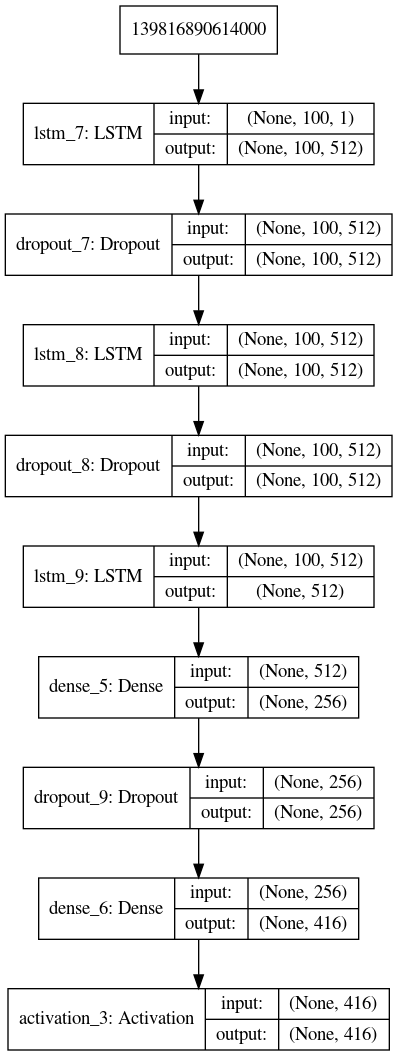

In [ ]:
Image(retina=True, filename='/home/victor/cursos/figs/midi_LSTM.png')

Ya que tienes el modelo entrenado y guardado, puedes generar una secuencia y guardarlo en archivo MIDI con el siguiente código

In [ ]:
def prepare_sequences_test(notes, pitchnames, n_vocab):
    """ Prepara las secuencias para usar en el modelo entrenado """
    
    # aqui, se realiza un mapeo (con diccionario) entre las notas y valores enteros y al reves
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 100
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # como antes, redimensionamos las entradas para poder usarse con LSTM
    normalized_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalizamos la entrada
    normalized_input = normalized_input / float(n_vocab)

    return (network_input, normalized_input)

def generate_notes_test(model, network_input, pitchnames, n_vocab):
    """ Genera notas musicales a partir de una red neuronal basado en una secuencia inicial de notas """
    
    # selecciona una secuencia aleatoria del input a partir de la cual se realizaran predicciones
    start = numpy.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # genera 500 notas (puedes cambiarlo)
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

def create_midi(prediction_output, midfile):
    """ genera un archivo MIDI a partir de las notas generadas (o predichas) """
    offset = 0
    output_notes = []

    # crea los objetos fundamentales Note y Chrod basado en los valores genrados por el modelo entrenado
    for pattern in prediction_output:
        # si las notas forman un acorde...
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # si son notas...
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # incremental el offset en cada iteracion. El offset es la posicion dentro del stream de musica
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp = midfile)


Suponiendo que ya creaste un modelo (my_model), lo entrenaste y LO GUARDASTE, el siguiente código genera la música a partir de ese modelo

In [ ]:
""" Genera las notas y el archivo MIDI (piano) """

# carga las notas usadas cuando se entreno el modelo
with open('/content/drive/My Drive/Tarea4/notes', 'rb') as filepath:
    notes = pickle.load(filepath)

# Obtiene el nombre de todas las notas (pitches)
pitchnames = sorted(set(item for item in notes))
n_vocab = len(set(notes))

""" Obtiene las secuencias Genera las notas y el archivo MIDI (piano) """
network_input, normalized_input = prepare_sequences_test(notes, pitchnames, n_vocab)

# carga el modelo entrenado
from keras.models import load_model
model = load_model('/content/drive/My Drive/Tarea4/midi_model.hdf5')
# genera las notas
prediction_output = generate_notes_test(model, network_input, pitchnames, n_vocab)
# crea el MIDI
create_midi(prediction_output, '/content/drive/My Drive/Tarea4/test_output.mid')

SUGERENCIAS: 
- Guarda tu modelo en formato hdf5. Puedes guardar todo o parte, por ejemplo, solo los pesos, pero tendrás que re-definir la arquitectura en la fase de test.
- Usa callbacks y model check points para guardar tu modelo en cada época. Puede tardar mucho tiempo para entrenarse...

Se propone un modelo muy similar a la arquitectura planteada previamente, con algunas de las capas LSTM con menor número de unidades ocultas, ya que se encontró esto ayuda a reducir significativamente el tiempo de entrenamiento produciendo resultados satisfactorios. Se entrenó el modelo tanto durante 30 épocas como por 100 épocas y se adjuntan los resultados de ambas estrategias para mejor comparación con respecto a la complejidad resultante. Se usa un tamaño de batch de 64 y el callback para guardar el progreso del modelo.

In [ ]:
midi_model = Sequential()
midi_model.add(LSTM(256,input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True))
midi_model.add(Dropout(0.3))
midi_model.add(LSTM(512, return_sequences=True))
midi_model.add(Dropout(0.3))
midi_model.add(LSTM(256))
midi_model.add(Dense(256))
midi_model.add(Dropout(0.3))
midi_model.add(Dense(n_vocab))
midi_model.add(Activation('softmax'))
midi_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [ ]:
midi_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 256)           264192    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 512)           1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [ ]:
filepath = "/content/drive/My Drive/Tarea4/midi_model_checkpoints.hdf5" 

checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]

In [ ]:
midi_model.fit(network_input, network_output, epochs=100, batch_size=64,callbacks=callbacks_list)

Epoch 1/100
3043/3043 [==============================] - 78s 26ms/step - loss: 4.7173
Epoch 2/100
3043/3043 [==============================] - 82s 27ms/step - loss: 4.6438
Epoch 3/100
3043/3043 [==============================] - 82s 27ms/step - loss: 4.5942
Epoch 4/100
3043/3043 [==============================] - 82s 27ms/step - loss: 4.5134
Epoch 5/100
3043/3043 [==============================] - 82s 27ms/step - loss: 4.3921
Epoch 6/100
3043/3043 [==============================] - 82s 27ms/step - loss: 4.2715
Epoch 7/100
3043/3043 [==============================] - 82s 27ms/step - loss: 4.1311
Epoch 8/100
3043/3043 [==============================] - 82s 27ms/step - loss: 3.9920
Epoch 9/100
3043/3043 [==============================] - 82s 27ms/step - loss: 3.8652
Epoch 10/100
3043/3043 [==============================] - 82s 27ms/step - loss: 3.7561
Epoch 11/100
3043/3043 [==============================] - 83s 27ms/step - loss: 3.6574
Epoch 12/100
3043/3043 [============================

In [ ]:
midi_model.save('/content/drive/My Drive/Tarea4/midi_model.hdf5')

## b) La generación de música que hicimos es muy básica y tiene varias limitaciones (¡pero aún así es sorprendente!). Una de ellas es que las notas generadas tienen solo una duración. Otra es que solo usan un instrumento. ¿Qué ideas se te ocurren para extender el método en ambos casos, que puedan implementarse en términos de redes recurrentes o Deep Learning en general?

## Quizá la lectura de Briot et al. (2019, 2017) y Huang & Wu (2016) puedan ayudar.

Una de las maneras en que se podría atacar la limitación del primer caso es explorar otras representaciones de la información distintas al formato MIDI. Una de las alternativas más interesantes que se encontraron en la obra de Briot, Hadjeres y Pachet (2007) es una representación de los acordes llamada _Chord2Vec_ inspirada en la representación vectorial de palabras _Word2Vec_. De esta manera se representan los acordes de manera vertical y para cada _time step_ las notas se representan como una secuencia delimitadas por un símbolo especial. Esta forma de trabajar con los datos fue de especial interés debido a que busca vectorizar información que puede ser tan compleja como una melodía, de manera similar a como se realiza con textos en el método de _World2Vec_.

Otra de las alternativas para representar la información y que, además de permitir trabajar con notas de distintas duraciones, nos permitiría también trabajar con música polifónica, es la de _piano rolls_. Esta representación contiene información sobre la __duración__ de la nota y su tono de acuerdo a la longitud y la ubicación de la _"perforación"_, termino que se toma del clásico papel con perforaciones utilizados para reproducir música en las pianoles (_automated pianos_). En esta representación se pueden incluir melodías tanto monódicas como __polifónicas__, es decir compuesta de distintos sonidos. En el artículo de se exploran las diferencias al utilizar la representación MIDI vs piano rolls, en la generación de música.

Además de buscar distintas representaciones, considero que una de las maneras más efectivas para crear música polifónica o multi-instrumental es explorar arquitecturas especiales para este tipo de música. Un ejemplo son las __RNN-RBM__ (_Recurrent Neural Network_-_Restricted Boltzmann Machine_) la cual las combina para asociar tanto la perspectiva vertical (notas simultáneas provenientes de distintos instrumentos) como la horizontal (secuencia de las notas). Otro ejemplo de las arquitecturas especiales para este tipo de música es la descrita por Hadjeres, Pachet y Nielsen (2017) como __DeepBach__. Esta arquitectura combina dos redes recurrentes (LSTM) y dos _feedforward_, lo cual permite tomar en cuenta la dirección del tiempo tanto hacia adelante como hacia atrás, ya que una de las redes recurrentes se usa para resumir la información pasada, otra para la información del futuro y las redes no recurrentes para las notas que ocurren al mismo tiempo. Esta arquitectura se resume en la siguiente imagen tomada de Briot et al. (2017).

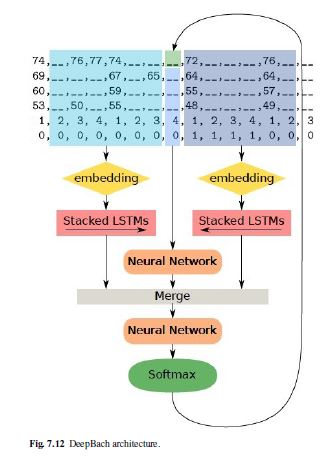

In [ ]:
Image(retina=True, filename='/content/drive/My Drive/Tarea4/DeepBach.JPG')